# Mlflow가 없다면??
<img width="1382" alt="image" src="https://user-images.githubusercontent.com/63439911/200203199-e41121e7-bfc4-4dc4-bf63-42156aa6d0da.png">



In [30]:
import torch.nn as nn
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import mlflow 
import warnings
import random

# Seed 고정


In [31]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정

seed = 42

seed_everything(seed)

# Model 정의

In [32]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,10)

    def forward(self, x):
        x1 = self.fc1(x)
        x2 = self.relu(x1)
        x3 = self.fc2(x2)
        x4 = self.relu(x3)
        x5 = self.fc3(x4)

        return x5

# Dataset 정의  
## MNIST Dataset을 사용하여 학습,검증을 합니다.

In [33]:
download_root = 'MNIST_data/'

train_dataset = datasets.MNIST(root=download_root,
                         train=True,
                         transform = transforms.ToTensor(),
                         download=True)
                         
test_dataset = datasets.MNIST(root=download_root,
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)    

# Batch_size, Train, Test Dataloader 정의

In [34]:
batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # batch_size : 책을 몇 장씩 넘길 지
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 학습률, Optimizer 정의

![image](https://user-images.githubusercontent.com/63439911/200167296-d804d2f3-1b16-40df-ac1b-191afb16d1e0.png)

In [35]:
model = Net()
model.zero_grad()
loss_function = nn.CrossEntropyLoss() # 실제 정답과 예측값의 차이를 수치화해주는 함수.
learning_rate = 0.001 # AdamW:0.001, SGD:0.1, Adam:0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # loss_function을 최소화 하는 모델의 파라미터를 찾는 방법.

# MLflow를 활용하여 학습진행

![image](https://user-images.githubusercontent.com/63439911/200161454-3710fd01-1989-4ba0-bbbd-78eef62df048.png)

In [36]:
warnings.filterwarnings(action='ignore')
experiment_name = 'chaos_AIP' # 실험명, 실험관리를 용이하게 해줍니다. 


if not mlflow.get_experiment_by_name(experiment_name): 
  mlflow.create_experiment(name=experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

mlflow.set_tracking_uri('http://127.0.0.1:5000') # 로컬 서버에 실행을 기록하기 위해 함수 호출

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

total_batch = len(train_loader)
epochs = 10


best_accuracy = 0
with mlflow.start_run(experiment_id=experiment.experiment_id,run_name="boom"):
  for epoch in range(epochs):
      cost=0
      model.train()
      train_accuracy = 0
      train_loss = 0
      for images, labels in train_loader:
          images = images.reshape(batch_size,784)
          
          optimizer.zero_grad() # 변화도 매개변수 0
          
          #forward
          pred = model(images)
          loss = loss_function(pred,labels)
          prediction = torch.argmax(pred,1)
          correct = (prediction == labels)
          train_accuracy += correct.sum().item() / 60000
          train_loss += loss.item() / 600
          
          #backward
          loss.backward()
          
          #Update
          optimizer.step()
          
          cost += loss
      
      with torch.no_grad(): #미분하지 않겠다는 것
          total = 0
          correct=0
          for images, labels in test_loader:
              images = images.reshape(batch_size,784)

              outputs = model(images)
              _,predict = torch.max(outputs.data, 1)

              total += labels.size(0)
              correct += (predict==labels).sum() # 예측한 값과 일치한 값의 합

      avg_cost = cost / total_batch
      accuracy = 100*correct/total
      
      val_loss_list.append(avg_cost.detach().numpy())
      val_acc_list.append(accuracy)

      if accuracy > best_accuracy:
        torch.save(model.state_dict(),'model.pt')
        mlflow.pytorch.log_model(model,'model') # pytorch.log_model 을 통해 모델을 기록합니다.
        best_accuracy = accuracy
        print(f"Save Model(Epoch: {epoch+1}, Accuracy: {best_accuracy:.5})")
      
      print("epoch : {} | loss : {:.6f}" .format(epoch+1, avg_cost))
      print("Accuracy : {:.2f}".format(100*correct/total))
      mlflow.log_param('learning-rate',learning_rate) # mlflow.log_param 을 사용하여 MLflow에 파라미터들을 기록할 수 있습니다.
      mlflow.log_param('epoch',epochs)
      mlflow.log_param('batch_size',batch_size)
      mlflow.log_param('seed',seed)
      mlflow.log_param('optimizer',optimizer)
      mlflow.log_param('loss_function',loss_function)
      mlflow.log_metric('train_accuracy',train_accuracy) # mlflow.log_metric을 사용하여 MLflow에 성능평가를 위한 metric을 기록할 수 있습니다.
      mlflow.log_metric('train_loss',train_loss)
      mlflow.log_metric('valid_accuracy',accuracy)
      mlflow.log_metric('valid_loss',avg_cost)
      print("------")
mlflow.end_run()

Save Model(Epoch: 1, Accuracy: 92.75)
epoch : 1 | loss : 0.496312
Accuracy : 92.75
------
Save Model(Epoch: 2, Accuracy: 94.64)
epoch : 2 | loss : 0.210700
Accuracy : 94.64
------
Save Model(Epoch: 3, Accuracy: 95.57)
epoch : 3 | loss : 0.154832
Accuracy : 95.57
------
Save Model(Epoch: 4, Accuracy: 96.39)
epoch : 4 | loss : 0.118749
Accuracy : 96.39
------
Save Model(Epoch: 5, Accuracy: 96.61)
epoch : 5 | loss : 0.094596
Accuracy : 96.61
------
Save Model(Epoch: 6, Accuracy: 96.99)
epoch : 6 | loss : 0.077565
Accuracy : 96.99
------
Save Model(Epoch: 7, Accuracy: 97.25)
epoch : 7 | loss : 0.065715
Accuracy : 97.25
------
Save Model(Epoch: 8, Accuracy: 97.43)
epoch : 8 | loss : 0.056217
Accuracy : 97.43
------
Save Model(Epoch: 9, Accuracy: 97.44)
epoch : 9 | loss : 0.046127
Accuracy : 97.44
------
epoch : 10 | loss : 0.039798
Accuracy : 97.43
------


In [37]:
import os
import json
import bentoml
import numpy as np
import pandas as pd
from torch import cuda

In [38]:
MLFLOW_PATH = './model_mlflow'

if not os.path.isdir(MLFLOW_PATH):
  mlflow.pytorch.save_model(model, MLFLOW_PATH) # mlflow 모델 로컬 디렉토리에 저장

bentoml.mlflow.import_model("mnist_clf", model_uri='./model_mlflow') # mlflow로 저장한 모델을 bentoml format에 맞추어 가져옴

Model(tag="mnist_clf:dgs5mss6kw5aqrzl", path="/home/khkim/bentoml/models/mnist_clf/dgs5mss6kw5aqrzl/")

In [39]:
!bentoml models list mnist_clf # 현재 등록되어 있는 모델 리스트 출력

 Tag                         Module          Size        Creation Time       
 mnist_clf:dgs5mss6kw5aqrzl  bentoml.mlflow  355.39 KiB  2022-11-07 13:31:51 
 mnist_clf:77awb7c6fkuoayzv  bentoml.mlflow  355.39 KiB  2022-11-07 08:30:29 
 mnist_clf:uh5rzxs372nxrayw  bentoml.mlflow  355.39 KiB  2022-11-04 14:07:51 
 mnist_clf:6atdu2s322nxrayw  bentoml.mlflow  355.39 KiB  2022-11-04 09:23:42 
 mnist_clf:rlzepcc3dw3donlu  bentoml.mlflow  355.39 KiB  2022-11-03 11:16:36 
 mnist_clf:evxuymc3as3donlu  bentoml.mlflow  355.39 KiB  2022-11-03 08:14:48 
 mnist_clf:mna6lfs2q2mr67oi  bentoml.mlflow  355.39 KiB  2022-11-02 17:14:35 
 mnist_clf:jisf22c2qkh6f2kn  bentoml.mlflow  355.39 KiB  2022-11-02 16:45:15 
 mnist_clf:bohyihc2qch6f2kn  bentoml.mlflow  355.39 KiB  2022-11-02 16:29:11 
 mnist_clf:y7m546s2noh6f2kn  bentoml.mlflow  355.39 KiB  2022-11-02 14:04:07 
 mnist_clf:pycdv6sy3wh6f2kn  bentoml.mlflow  355.39 KiB  2022-10-31 14:33:04 
 mnist_clf:klquv2syykh6f2kn  bentoml.mlflow  355.39 KiB  2022-10

# Inference

In [40]:
# mnist 테스트 데이터 가져오기
with open('./test_input.json', 'r') as f:
  test_input_arr = np.array(json.load(f), dtype=np.float32)

len(test_input_arr) # test 데이터 개수

3

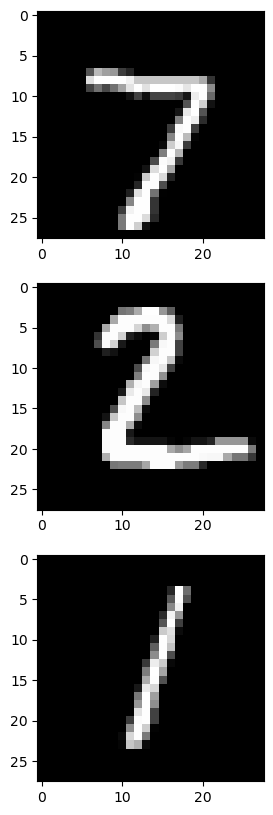

In [41]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(len(test_input_arr),1,figsize=(10,10))
for i in range(len(test_input_arr)):
    img = test_input_arr[i]
    img = img.reshape(28,28,1)
    axes[i].imshow(img,'gray')

plt.show()
    

In [ ]:
# API 테스트
runner = bentoml.mlflow.get("mnist_clf:latest").to_runner()
runner.init_local()
result = runner.predict.run(test_input_arr)

for i in result:
    print(np.argmax(i))

'Runner.init_local' is for debugging and testing only.
2022/11/07 08:31:30 WARNING mlflow.pyfunc: The version of Python that the model was saved in, `Python 3.10.8`, differs from the version of Python that is currently running, `Python 3.9.12`, and may be incompatible


7
2
1


In [ ]:
!bentoml serve service:svc --reload

2022-10-31T11:18:42+0900 [INFO] [cli] Prometheus metrics for HTTP BentoServer from "service:svc" can be accessed at http://localhost:3000/metrics.
2022-10-31T11:18:43+0900 [INFO] [cli] Starting development HTTP BentoServer from "service:svc" running on http://0.0.0.0:3000 (Press CTRL+C to quit)
2022-10-31 11:18:44 circus[2119121] [INFO] Loading the plugin...
2022-10-31 11:18:44 circus[2119121] [INFO] Endpoint: 'tcp://127.0.0.1:36727'
2022-10-31 11:18:44 circus[2119121] [INFO] Pub/sub: 'tcp://127.0.0.1:39683'
2022-10-31T11:18:44+0900 [INFO] [observer] Watching directories: ['/home/khkim/aip/AIP', '/home/khkim/bentoml/models']
^C
